In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn

import pymongo
import pymongo.database

import pandas as pd
import matplotlib.pyplot as plt





import sys
sys.path.append('../')
import src.IQ as IQ

## Connecting to the database

In [2]:
myclient = pymongo.MongoClient("mongodb://127.0.0.1:27017/admin")
BLE = myclient["BLE"]

def query(collection, filter:dict, addFrameColumn=False):
    df =  pd.DataFrame(list(collection.find(filter)))
    if addFrameColumn:
        df['frame'] = df.apply(lambda x: x['I'] + np.dot(x['Q'],1j), axis=1)
    return df.copy()


## Modifying the DataFram
### keeping the necessary colunms  only

In [3]:
def df_modify(df):
    if 'txPower' in df.columns:
        df_temp = df[['I','Q','frame','dvc','pos', 'antenna', 'txPower','SDR','frameChnl']].copy()
        df_temp['txPower'] = df.apply(lambda x: 9 if x['txPower'] == '9dbm' else 3, axis=1)
        df_temp[['dvc','pos', 'antenna', 'txPower','SDR','frameChnl']] = df_temp[['dvc','pos', 'antenna', 'txPower','SDR','frameChnl']].astype('int')
    else:
        df_temp = df[['I','Q','frame','dvc','pos', 'antenna', 'antenna_side','SDR','frameChnl']].copy()
        df_temp['antenna_side'] = df.apply(lambda x: 0 if x['antenna_side'] == 'left' else 1, axis=1)
        df_temp['pos'] = df.apply(lambda x: 0 if x['pos'] == 'static' else 1, axis=1)
        df_temp[['dvc','pos', 'antenna','SDR','frameChnl']] = df_temp[['dvc','pos', 'antenna','SDR','frameChnl']].astype('int')
    return df_temp.copy()

## Feature Extraction
### Extracting feature under differetn sampling rates and different filtering situations

In [4]:
iq = IQ.IQ(Fc=2439810000+1.5e4,Fs=100e6)
def configCreator(downSampleRate = 1, cutoff = 1e6):
    downSampleRate= max(downSampleRate, 1)
    return {                                      
            iq.bitFinderFromPhaseGradient:{'Fs': iq.Fs/downSampleRate, 'plot':False},
            iq.scalePhaseGradientToHz: {'Fs': iq.Fs/downSampleRate}, 
            iq.gradient:{},
            iq.unwrapPhase:{},
            iq.phase:{}, 
            iq.butter:{'Fs': iq.Fs/downSampleRate, "cutoff": cutoff},
            iq.downSample:{'downSampleRate':downSampleRate, "shift": 0},
            iq.demodulate:{'Fs': iq.Fs},
           }

def RSSIconfigCreator(downSampleRate = 1, cutoff = 1e6):
    downSampleRate= max(downSampleRate, 1)
    return {
            iq.rssi:{},                                      
            iq.butter:{'Fs': iq.Fs/downSampleRate, "cutoff": cutoff},
            iq.downSample:{'downSampleRate':downSampleRate, "shift": 0},
            iq.demodulate:{'Fs': iq.Fs},
           }

configurations = { 
    'butter4MHz_Fs100MHz': configCreator(downSampleRate = 1, cutoff=4e6), 
    'butter4MHz_Fs10MHz': configCreator(downSampleRate=  10, cutoff=4e6), 
    
    
    'butter2MHz_Fs100MHz': configCreator(downSampleRate = 1, cutoff=2e6), 
    'butter2MHz_Fs10MHz': configCreator(downSampleRate=  10, cutoff=2e6), 
    'butter2MHz_Fs5MHz': configCreator(downSampleRate = 20,  cutoff=2e6), 
     
    'butter1MHz_Fs100MHz': configCreator(downSampleRate = 1), 
    'butter1MHz_Fs10MHz': configCreator(downSampleRate=  10), 
    'butter1MHz_Fs5MHz': configCreator(downSampleRate = 20), 
    'butter1MHz_Fs2.5MHz': configCreator(downSampleRate = 40), 
}
configurationRSSI = {
    'butter4MHz_Fs100MHz': RSSIconfigCreator(downSampleRate = 1, cutoff=4e6), 
    'butter4MHz_Fs10MHz': RSSIconfigCreator(downSampleRate=  10, cutoff=4e6), 
    
    
    'butter2MHz_Fs100MHz': RSSIconfigCreator(downSampleRate = 1, cutoff=2e6), 
    'butter2MHz_Fs10MHz': RSSIconfigCreator(downSampleRate=  10, cutoff=2e6), 
    'butter2MHz_Fs5MHz': RSSIconfigCreator(downSampleRate = 20,  cutoff=2e6), 
     
    'butter1MHz_Fs100MHz': RSSIconfigCreator(downSampleRate = 1), 
    'butter1MHz_Fs10MHz': RSSIconfigCreator(downSampleRate=  10), 
    'butter1MHz_Fs5MHz': RSSIconfigCreator(downSampleRate = 20), 
    'butter1MHz_Fs2.5MHz': RSSIconfigCreator(downSampleRate = 40), 
}

### Extracting RSSI, Center Freq., firstBitLength, and [overshoot, STD, mean, len] of freq. Deviation

For every frequency deviation the overshoot STD mean len is calculated and grouped by it's length (length corresponds to the number of intended consecutive bits)


In [5]:
plt.rcParams.update({'font.size': 18})
def configDF_creator(X):
    iq.Warnings = False
    res = pd.DataFrame({})

    for config in configurations.keys():
        temp = iq.apply(methods=configurations[config], frame=X)
        res[config+'_firstBitLength'] = temp.apply(lambda x: x['len'][0])
        temp = temp.apply(lambda x: x[['len','numberOfBits', 'overshoot', 'std', 'mean']].groupby('numberOfBits').mean())
        for n in [0,1,2]:
            try:
                res[config+'_overshoot {} bit'.format(n+1)] = temp.apply(lambda x: list(x['overshoot'])[n])
                res[config+'_std {} bit'.format(n+1)] = temp.apply(lambda x: list(x['std'])[n])
                res[config+'_mean {} bit'.format(n+1)] = temp.apply(lambda x: list(x['mean'])[n])
                res[config+'_len {} bit'.format(n+1)] = temp.apply(lambda x: list(x['len'])[n])
            except:
                pass
            
    X = pd.concat([X, res], axis=1)

    res = pd.DataFrame({})
    for config in configurationRSSI.keys():
        res[config+'_rssi'] = abs(iq.apply(methods=configurationRSSI[config], frame=X))
    X = pd.concat([X, res], axis=1)
    iq.Warnings = True
    return X



## APPLYING ML models

In [6]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import seaborn as sns

clfs={}
accuracy = {}
random_state = 42


plt.rcParams.update({'font.size': 12})

def mlTrain(clf, name, i, xy = None):
    X_train, X_test, y_train, y_test = xy
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    plt.subplot(1,5,i)
    sns.heatmap(confusion_matrix(y_test, y_pred),annot=True,fmt="d")
    accu = np.round(accuracy_score(y_test, y_pred),2)
    accuracy[name] = accu
    plt.title(name + ", "+str(accu))

def mlRun(xy , cnt = 1):
    for clf in clfs:
        mlTrain(clfs[clf], clf, cnt,xy = xy )
        cnt+=1
    return cnt

    # print(classification_report(y_test, y_pred))







# clfs['SVM'] = svm.SVC()
clfs['randomForest'] = RandomForestClassifier(n_estimators=100, max_depth=5,random_state=random_state)
clfs['KNN'] = KNeighborsClassifier(n_neighbors=5)
# clfs['Naive Bayse'] = GaussianNB()
# clfs['logreg'] = LogisticRegression()
clfs['DecisionTree'] = DecisionTreeClassifier(random_state=random_state)
# clfs['MLPClassifier'] = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
# clfs['AdaBoostClassifier'] = AdaBoostClassifier(n_estimators=100, random_state=random_state)
# clfs['GradientBoostingClassifier'] = GradientBoostingClassifier(random_state=random_state)
clfs['ExtraTreesClassifier'] = ExtraTreesClassifier(n_estimators=100, random_state=random_state)
# clfs['BaggingClassifier'] = BaggingClassifier(base_estimator=LogisticRegression(),
# n_estimators=10, random_state=random_state).fit(X_train, y_train)




from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
estimators = [
('lr', LogisticRegression(random_state=0)),
('rf', RandomForestClassifier(n_estimators=100, max_depth=5,random_state=0)),
('gnb', DecisionTreeClassifier(random_state=0)),
('svm', ExtraTreesClassifier(n_estimators=100, random_state=0))]
clfs['VotingClassifier'] = VotingClassifier(estimators=estimators, voting='hard')

In [7]:
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
import sklearn.model_selection
import warnings
warnings.filterwarnings('ignore')
def normalized_Train_And_Test_Creator(X,y, smote=False, normalize=True, random_state=42):
    Xcopy = X.copy()
    ycopy = y.copy()
    if normalize:
        min_max_scaler = preprocessing.MinMaxScaler()
        Xcopy = min_max_scaler.fit_transform(X)
        Xcopy = pd.DataFrame(Xcopy)
    if smote:
        smote = SMOTE(k_neighbors=1)
        Xcopy, ycopy = smote.fit_resample(Xcopy, ycopy)

    return sklearn.model_selection.train_test_split(Xcopy, ycopy, test_size=0.2, random_state=random_state)

def runForX(X, smote=False, normalize=True, random_state=random_state):
    for config in configurations.keys():
        temp  = configDF_creator(X)
        temp = pd.concat([temp.filter(like=config),temp['frameChnl'],temp['dvc']], axis=1)
        y = temp.pop('dvc')
        print(config, len(temp.columns), temp.columns)
        xy = normalized_Train_And_Test_Creator(temp, y, smote=smote, normalize=normalize, random_state=random_state)   
        cnt =  1
        figure = plt.figure(figsize=(20,5))
        cnt = mlRun(xy, cnt= cnt)
        print(config ,accuracy)


In [8]:
df = query(BLE['onBody'], {'pos':'static','SDR':'1','antenna_side':'left'}, addFrameColumn=True)
df_offBody = df_modify(df)
runForX(df_offBody[0:300])

butter4MHz_Fs100MHz 15 Index(['butter4MHz_Fs100MHz_firstBitLength',
       'butter4MHz_Fs100MHz_overshoot 1 bit', 'butter4MHz_Fs100MHz_std 1 bit',
       'butter4MHz_Fs100MHz_mean 1 bit', 'butter4MHz_Fs100MHz_len 1 bit',
       'butter4MHz_Fs100MHz_overshoot 2 bit', 'butter4MHz_Fs100MHz_std 2 bit',
       'butter4MHz_Fs100MHz_mean 2 bit', 'butter4MHz_Fs100MHz_len 2 bit',
       'butter4MHz_Fs100MHz_overshoot 3 bit', 'butter4MHz_Fs100MHz_std 3 bit',
       'butter4MHz_Fs100MHz_mean 3 bit', 'butter4MHz_Fs100MHz_len 3 bit',
       'butter4MHz_Fs100MHz_rssi', 'frameChnl'],
      dtype='object')
butter4MHz_Fs100MHz {'randomForest': 0.85, 'KNN': 0.87, 'DecisionTree': 0.87, 'ExtraTreesClassifier': 0.92, 'VotingClassifier': 0.88}
butter4MHz_Fs10MHz 15 Index(['butter4MHz_Fs10MHz_firstBitLength',
       'butter4MHz_Fs10MHz_overshoot 1 bit', 'butter4MHz_Fs10MHz_std 1 bit',
       'butter4MHz_Fs10MHz_mean 1 bit', 'butter4MHz_Fs10MHz_len 1 bit',
       'butter4MHz_Fs10MHz_overshoot 2 bit', 'butter4

In [ ]:
X[0:1]['RRSI'+config]

NameError: name 'X' is not defined

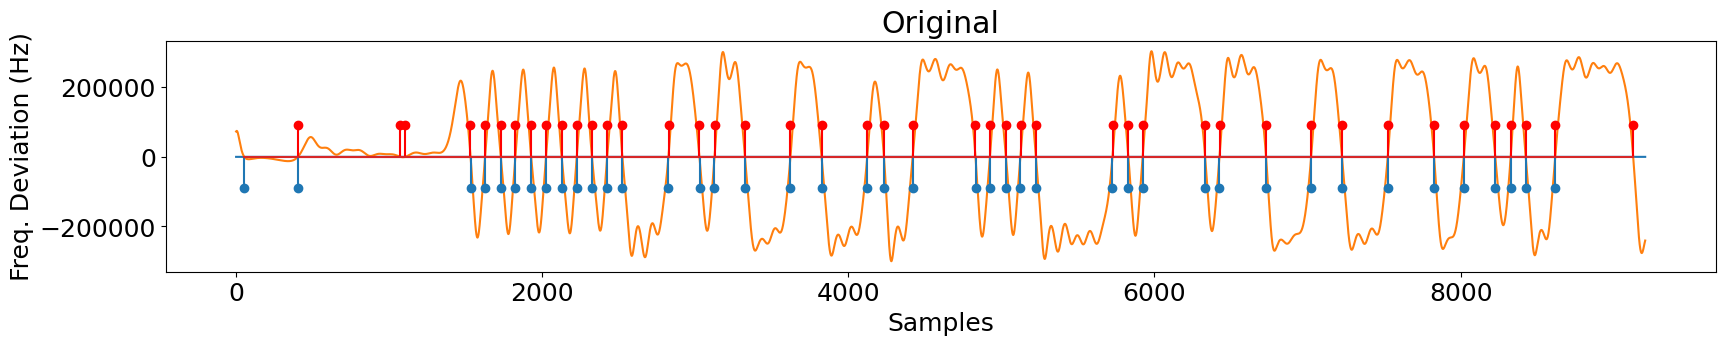

0     218902.855403
1     231969.754732
2     247374.512905
3     221848.316044
4     250782.434206
5     217381.842918
6     256583.907198
7     219676.020251
8     253927.855588
9     212118.428081
10    246491.988901
11    288419.977761
12    269362.576800
13    212334.005754
14    301220.461178
15    269420.488328
16    273231.160671
17    283833.273311
18    216322.876266
19    299829.669495
20    281258.678587
21    229205.905066
22    251056.655201
23    224459.547272
24    242138.711376
25    293316.953227
26    233043.584597
27    226684.444230
28    303481.016309
29    213231.665527
30    292853.092426
31    269699.296453
32    278762.609779
33    266920.073193
34    278632.737084
35    264573.573570
36    283404.492282
37    196337.310923
38    259617.734101
39    282662.942806
40    286459.190981
Name: samples, dtype: float64

In [ ]:
df = query(BLE['offBody'], {'antenna': '1','SDR':'1' , 'dvc':{'$in': ['5']}}, addFrameColumn=True)
df_offBody = df_modify(df)
y = df_offBody.pop('dvc')
X = df_offBody
methods={ 
    iq.bitFinderFromPhaseGradient:{'plot': True, 'noGroupBefore':0, "title": 'Original'},
    iq.scalePhaseGradientToHz: None,
    iq.gradient:{},
    iq.unwrapPhase:{},
    iq.phase:{}, 
    iq.butter:{},
    iq.demodulate:{},
}
yy10_0 = iq.apply(methods=methods, frame = X[0:1])
yy10_0[0]['samples'].apply(lambda x: max(abs(x)))

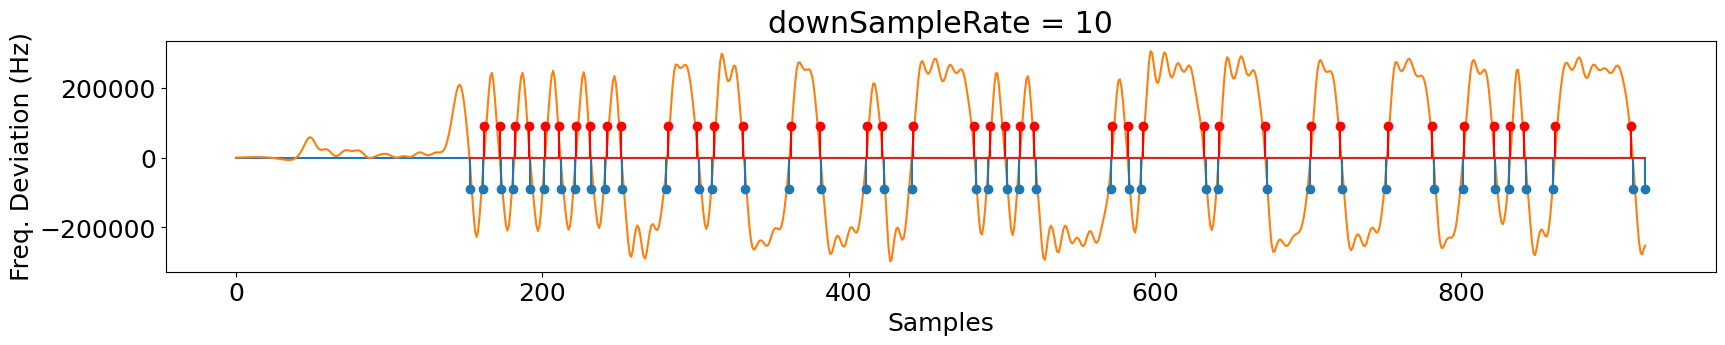

In [ ]:
# How DownSampling effects the signal
downSampleRate = 10
methods={                                      
    iq.bitFinderFromPhaseGradient:{'Fs': 10e6, 'smallerThan': 100, 'biggerThan': 7, 'noGroupBefore': 125, 'plot': True, "title": 'downSampleRate = 10'},
    iq.scalePhaseGradientToHz: {'Fs': iq.Fs/downSampleRate}, 
    iq.gradient:{},
    iq.unwrapPhase:{},
    iq.phase:{}, 
    iq.butter:{'Fs': iq.Fs/downSampleRate},
    iq.downSample:{'downSampleRate':downSampleRate, "shift": 0},
    iq.demodulate:{'Fs': iq.Fs},
}
yy10 = iq.apply(methods=methods, frame = X[0:1])


In [ ]:
def df_to_tensor(df: pd.DataFrame):
    y = df.pop('dvc').to_numpy()-1
    X = df.to_numpy() 
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y ,
                                                                                random_state=104, 
                                                                                test_size=0.25, 
                                                                                shuffle=True
                                                                                )
    return torch.from_numpy(X_train).float(),torch.from_numpy(X_test).float(), torch.from_numpy(y_train).int(), torch.from_numpy(y_test).int()

In [ ]:


# %%
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=6, out_features=1000),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1000, out_features=10000),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=10000, out_features=1000),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1000, out_features=13),
)



In [ ]:
ce_loss = nn.CrossEntropyLoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.01)

# %%
kl_weight = 0.1

# %%
for step in range(3000):
    pre = model(x)
    ce = ce_loss(pre, y)
    kl = kl_loss(model)
    cost = ce + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
_, predicted = torch.max(pre.data, 1)
total = y.size(0)
correct = (predicted == y).sum()
print('- Accuracy: %f %%' % (100 * float(correct) / total))
print('- CE : %2.2f, KL : %2.2f' % (ce.item(), kl.item()))

NameError: name 'x' is not defined